## Librerias

In [90]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score,classification_report
from sklearn.model_selection import TimeSeriesSplit
import optuna
import numpy as np
import shap
import matplotlib.pyplot as plt
import joblib

scaler = RobustScaler()
le = LabelEncoder()


# Lectura del Archivo

El dataset integrado tiene relacionados datos de sentimientos y acciones por fecha

In [91]:
fileName= "data_set_integrado_modelo_final_futuro_binario.csv"
path="../franco/"

# Read the CSV file
df = pd.read_csv(path + fileName)
df = df.sort_values('fecha')

In [92]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 2909 entries, 0 to 2908
Data columns (total 76 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id_cotizacion                              2909 non-null   int64  
 1   id_empresa                                 2909 non-null   int64  
 2   fecha                                      2909 non-null   object 
 3   precio_apertura                            2909 non-null   float64
 4   precio_cierre                              2909 non-null   float64
 5   precio_max                                 2909 non-null   float64
 6   precio_min                                 2909 non-null   float64
 7   volumen_operado                            2909 non-null   float64
 8   variacion_porcentaje                       2862 non-null   float64
 9   nombre                                     2909 non-null   object 
 10  label                        

,id_cotizacion,id_empresa,fecha,precio_apertura,precio_cierre,precio_max,precio_min,volumen_operado,variacion_porcentaje,nombre,...,total_noticias_positivas_std_3d,total_noticias_positivas_media_5d,total_noticias_positivas_std_5d,total_noticias_negativas_media_3d,total_noticias_negativas_std_3d,total_noticias_negativas_media_5d,total_noticias_negativas_std_5d,ratio_sent_positivo_negativo,diff_score_sentimiento,label_t_plus_1
0,901,10,2024-01-02,18.90,18.80,19.30,18.70,66824.55,-1.827676,AAPLD,...,3.464102,1.2,2.683282,3.000000,5.196152,1.8,4.024922,-0.481708,6.8366,NO_SUBE
645,2009,12,2024-01-02,11.80,12.15,12.25,11.65,313095.56,2.966102,KOD,...,3.464102,1.2,2.683282,3.000000,5.196152,1.8,4.024922,-0.481708,6.8366,SUBE
1941,4224,16,2024-01-02,37.50,37.05,38.00,37.00,0.00,0.000000,TEND,...,3.464102,1.2,2.683282,3.000000,5.196152,1.8,4.024922,-0.481708,6.8366,NO_SUBE
969,2563,13,2024-01-02,26.25,25.60,26.45,25.05,40776.50,-1.348748,MELID,...,3.464102,1.2,2.683282,3.000000,5.196152,1.8,4.024922,-0.481708,6.8366,NO_SUBE
324,1455,11,2024-01-02,9.50,9.50,9.50,9.50,9.50,0.000000,DESPD,...,3.464102,1.2,2.683282,3.000000,5.196152,1.8,4.024922,-0.481708,6.8366,NO_SUBE
2585,5332,18,2024-01-02,20.20,20.70,20.85,19.80,6848.60,1.470588,XOMD,...,3.464102,1.2,2.683282,3.000000,5.196152,1.8,4.024922,-0.481708,6.8366,SUBE
1617,3671,15,2024-01-02,21.15,20.25,21.15,20.05,22327.85,-2.644231,NVDAD,...,3.464102,1.2,2.683282,3.000000,5.196152,1.8,4.024922,-0.481708,6.8366,SUBE
1293,3117,14,2024-01-02,12.65,12.35,12.75,12.05,27249.75,-2.371542,MSFTD,...,3.464102,1.2,2.683282,3.000000,5.196152,1.8,4.024922,-0.481708,6.8366,SUBE
2261,4778,17,2024-01-02,29.85,29.25,29.90,28.70,47863.00,-1.015228,VISTD,...,3.464102,1.2,2.683282,3.000000,5.196152,1.8,4.024922,-0.481708,6.8366,SUBE
646,2010,12,2024-01-03,12.15,12.20,12.35,11.90,290101.81,0.411523,KOD,...,6.000000,3.6,5.366563,6.333333,5.507571,3.8,5.215362,-1.119817,11.1142,SUBE


Codifico el target

In [93]:
df['target'] = le.fit_transform(df['label_t_plus_1'])  # SUBE=1, NO_SUBE=0

Tratamiento de valores nulos

Para el tratamiento de valores nulos se uso la Mediana de cada variable

In [94]:
sentiment_cols = ['suma_score_sentimiento_positivas', 'suma_score_sentimiento_negativas',
                 'ratio_sent_positivo_negativo', 'diff_score_sentimiento']
for col in sentiment_cols:
    df[col] = df[col].fillna(df[col].median())

Agrego dos features adicionales

In [95]:
df['sentimiento_volatilidad'] = df['suma_score_sentimiento_positivas'] * df['precio_cierre_std_5d']
df['momentum_compuesto'] = df['tendencia_precio_5d'] * df['volumen_operado_media_5d']

Selecciono FEATURES claves

In [98]:
features = [
    # Precios y volumen
    'precio_cierre', 'volumen_operado', 'precio_cierre_lag_1', 
    'precio_cierre_media_5d', 'precio_cierre_std_5d', 'variacion_porcentaje',
    
    # Sentimiento
    'suma_score_sentimiento_positivas', 'ratio_sent_positivo_negativo', 
    'suma_score_sentimiento_positivas_lag_1', 'diff_score_sentimiento',
    
    # Temporales
    'dia_semana', 'es_fin_de_mes',
    
    # Tendencias e interacciones
    'tendencia_precio_5d', 'sentimiento_volatilidad', 'momentum_compuesto'
]

target = 'target'

# Modelado de Lightgbm

In [99]:
# División temporal (80% train, 20% test)
train_size = int(0.8 * len(df))
X_train, X_test = df[features].iloc[:train_size], df[features].iloc[train_size:]
y_train, y_test = df[target].iloc[:train_size], df[target].iloc[train_size:]

# Escalar features numéricas (opcional para LightGBM)

In [100]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Optimizacion de Hipeparametros usando **OPTUNA**

In [102]:
def optimize_hyperparams(X_train, y_train, X_test, y_test, n_trials=30):
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'boosting_type': 'dart',
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 5),
            'lambda_l2': trial.suggest_float('lambda_l2', 0, 5),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
            'verbose': -1
        }
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return f1_score(y_test, y_pred)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

In [103]:
# Ejecutar optimización (comentar si no se desea)
best_params = optimize_hyperparams(X_train_scaled, y_train, X_test_scaled, y_test)
print("Mejores hiperparámetros:", best_params)

[I 2025-05-03 17:18:28,640] A new study created in memory with name: no-name-d6390222-b1b5-4fb4-93de-2cb611b28f83
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-03 17:18:28,900] Trial 0 finished with value: 0.4419642857142857 and parameters: {'num_leaves': 34, 'learning_rate': 0.10640573176767824, 'feature_fraction': 0.8395745485637205, 'bagging_fraction': 0.7896656311343428, 'lambda_l1': 0.2497523812463942, 'lambda_l2': 4.588087714344899, 'min_data_in_leaf': 24}. Best is trial 0 with value: 0.4419642857142857.
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid fe

Mejores hiperparámetros: {'num_leaves': 96, 'learning_rate': 0.25612483427188165, 'feature_fraction': 0.9360307058255748, 'bagging_fraction': 0.876471158080031, 'lambda_l1': 1.3525727286041145, 'lambda_l2': 3.532164246611385, 'min_data_in_leaf': 40}


# Entrenamiento del modelo usando los mejores parametros obtenidos de OPTUNA

In [ ]:
# Entrenar modelo final
final_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'dart',
    'num_leaves': 96,
    'min_data_in_leaf': 40,
    'learning_rate': 0.25612483427188165,
    'feature_fraction': 0.9360307058255748,
    'lambda_l1': 1.3525727286041145,
    'lambda_l2': 3.532164246611385,
    'verbose': -1
}

model = lgb.LGBMClassifier(**final_params)
model.fit(X_train_scaled, y_train, 
          eval_set=[(X_test_scaled, y_test)],
          eval_metric='binary_logloss',
          callbacks=[
                        lgb.early_stopping(stopping_rounds=50),   # detiene si no mejora en 50 iter
                        lgb.log_evaluation(period=10)             # imprime log cada 10 iter
                    ]
)


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.689824
[20]	valid_0's binary_logloss: 0.708112
[30]	valid_0's binary_logloss: 0.712508
[40]	valid_0's binary_logloss: 0.708844
[50]	valid_0's binary_logloss: 0.708039
[60]	valid_0's binary_logloss: 0.703787
[70]	valid_0's binary_logloss: 0.702405
[80]	valid_0's binary_logloss: 0.701851
[90]	valid_0's binary_logloss: 0.699233
[100]	valid_0's binary_logloss: 0.700125


LGBMClassifier(boosting_type='dart', feature_fraction=0.9360307058255748,
               lambda_l1=1.3525727286041145, lambda_l2=3.532164246611385,
               learning_rate=0.25612483427188165, metric='binary_logloss',
               min_data_in_leaf=40, num_leaves=96, objective='binary',
               verbose=-1)

## Evaluacion

/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Reporte de Clasificación:
              precision    recall  f1-score   support

     NO_SUBE       0.66      0.62      0.64       351
        SUBE       0.47      0.51      0.49       231

    accuracy                           0.58       582
   macro avg       0.56      0.57      0.56       582
weighted avg       0.58      0.58      0.58       582



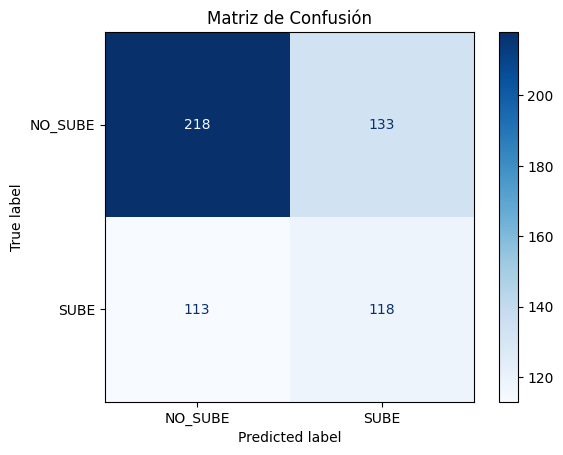

In [105]:
# ----------------------------------------------------------
# 4. EVALUACIÓN DEL MODELO
# ----------------------------------------------------------
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probabilidades para SUBE

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['NO_SUBE', 'SUBE']))

# Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO_SUBE', 'SUBE'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

In [118]:
print(cm)

[[218 133]
 [113 118]]


# Interpretacion con SHAP (Shapley Additive Explanations)
Esta libreria es un marco teorico que se utiliza para explicar el resultado de cualquier modelo de ML.

In [106]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Feature importance

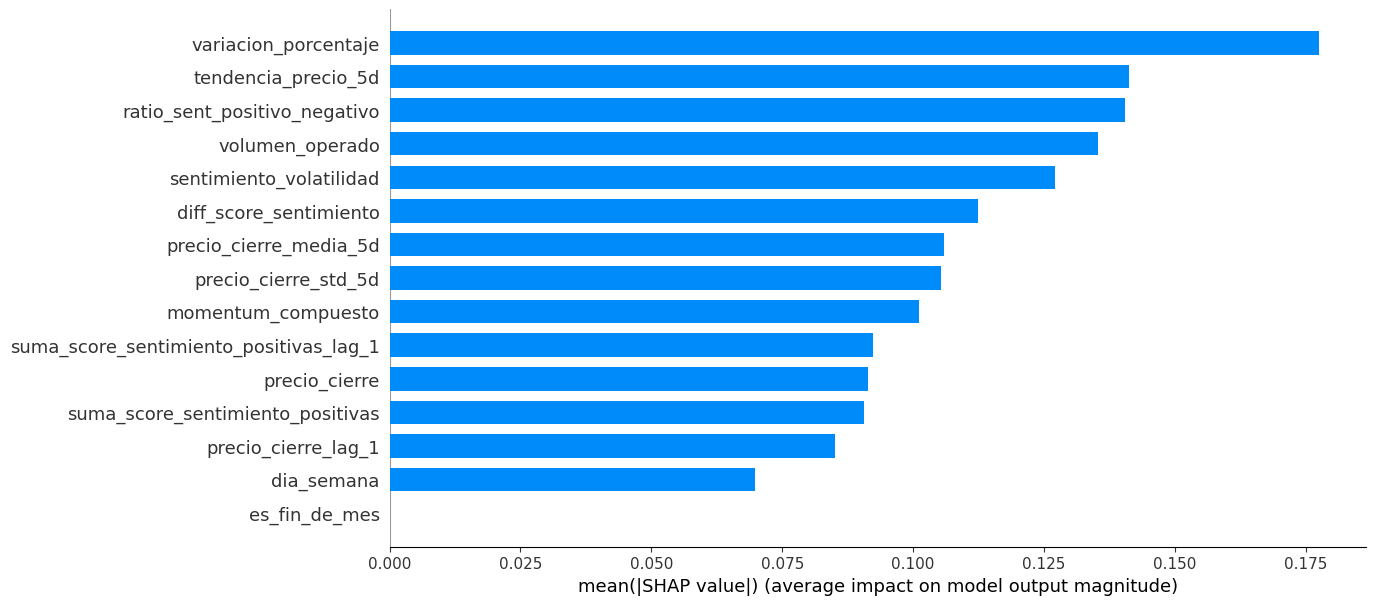

In [117]:
plt.figure()
shap.summary_plot(shap_values, X_test_scaled, feature_names=features, plot_type="bar",show=False)
# Ajustar el tamaño del gráfico
plt.gcf().set_size_inches(20, 6)  # Cambia el tamaño según tus necesidades (ancho, alto)

# Mostrar el gráfico
plt.show()


AssertionError: 'shap_values' and 'features' values must have the same number of rows!

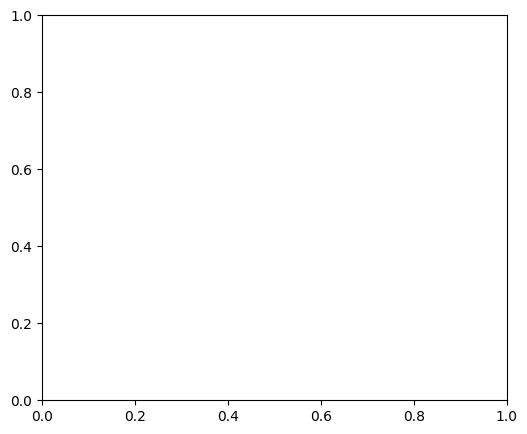

In [108]:
# Dependencia para una feature clave (ej: sentimiento)
shap.dependence_plot("suma_score_sentimiento_positivas", shap_values[1], X_test_scaled, 
                     feature_names=features, interaction_index=None)
plt.title("Dependencia del Sentimiento Positivo")
plt.show()

# 6. BACKTESTING SIMPLE

In [83]:
df_test = df.iloc[train_size:].copy()
df_test['prediccion'] = y_proba
df_test['decision'] = np.where(df_test['prediccion'] > 0.6, 1, 0)  # Umbral ajustable

# Calcular retorno acumulado de la estrategia
df_test['retorno_estrategia'] = df_test['decision'] * df_test['variacion_porcentaje'].shift(-1)

print("\nResultados de Backtesting:")
print(f"Retorno acumulado: {df_test['retorno_estrategia'].sum():.2f}%")
print(f"Cantidad de operaciones: {df_test['decision'].sum()}")


Resultados de Backtesting:
Retorno acumulado: 68.22%
Cantidad de operaciones: 131


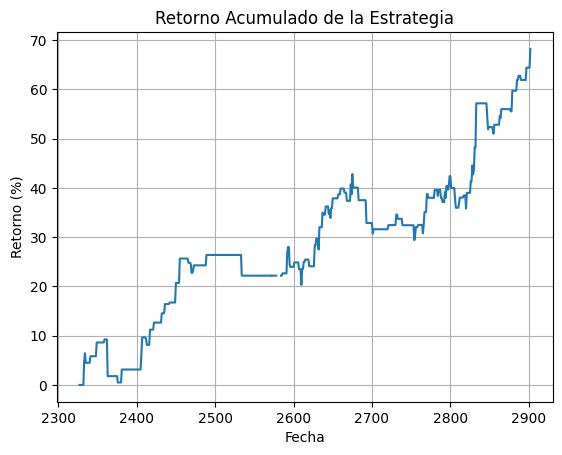

In [84]:
# Gráfico de retornos acumulados
df_test['retorno_acumulado'] = df_test['retorno_estrategia'].cumsum()
df_test['retorno_acumulado'].plot(title='Retorno Acumulado de la Estrategia')
plt.xlabel('Fecha')
plt.ylabel('Retorno (%)')
plt.grid()
plt.show()

# 7. GUARDAR MODELO Y FEATURES

In [85]:
joblib.dump(model, 'modelo_lightgbm.pkl')
joblib.dump(scaler, 'scaler.pkl')
pd.Series(features).to_csv('features_seleccionadas.csv', index=False)

print("\n¡Modelo entrenado y guardado correctamente!")


¡Modelo entrenado y guardado correctamente!
